In [1]:
# IMPORT LIBRARY
import pandas as pd
import re
import string
import nltk
from num2words import num2words
import requests
from io import BytesIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm

In [2]:
# MUAT DATASET
data = pd.read_csv("datasetmbgfixx2.csv")
data

,Unnamed: 0.1,Unnamed: 0,id,created_at,date,user_name,screen_name,Sentimen_Title,text,retweets,replies,likes,quotes
0,0,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,netral,Pemerintah meluncurkan program makan gratis ta...,0.226435,0.18852,1.140074,0.022117
1,1,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,negatif,"Harusnya lebih diawasi, banyak sekolah belum d...",0.226435,0.18852,1.140074,0.022117
2,2,1002.000000,1.974023e+18,2025-10-03 8:04:10,2025-10-03,hana_YOUrpilofjoy,hi_hana275,negatif,@paauuuw Maaf aku bacanya meeting mbg. Sedikit...,0.000000,1.00000,0.000000,0.000000
3,3,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,netral,Pemerintah meluncurkan program makan gratis ta...,0.226435,0.18852,1.140074,0.022117
4,4,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,negatif,"Masih banyak kekurangan, terutama distribusiny...",0.226435,0.18852,1.140074,0.022117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4894,4894,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,negatif,"Harusnya lebih diawasi, banyak sekolah belum d...",0.226435,0.18852,1.140074,0.022117
4895,4895,550.000000,1.974004e+18,2025-10-03 6:48:33,2025-10-03,street lawyers,streetlawyers85,negatif,Pelaksanaan MBG terkesan kurang terorganisir d...,0.000000,0.00000,0.000000,0.000000
4896,4896,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,positif,"Terima kasih atas program ini, semoga terus be...",0.226435,0.18852,1.140074,0.022117
4897,4897,1031.954186,1.974021e+18,2025-10-03 8:51:21,2025-10-03,Sapraji,saprajie,negatif,"Masih banyak kekurangan, terutama distribusiny...",0.226435,0.18852,1.140074,0.022117


In [3]:
# Hapus kolom yang tidak dibutuhkan
data = data.drop(columns=[
    'id', 'date', 'created_at', 'user_name',
    'screen_name', 'retweets', 'replies', 'likes', 'quotes','Unnamed: 0'
])
data

,Unnamed: 0.1,Sentimen_Title,text
0,0,netral,Pemerintah meluncurkan program makan gratis ta...
1,1,negatif,"Harusnya lebih diawasi, banyak sekolah belum d..."
2,2,negatif,@paauuuw Maaf aku bacanya meeting mbg. Sedikit...
3,3,netral,Pemerintah meluncurkan program makan gratis ta...
4,4,negatif,"Masih banyak kekurangan, terutama distribusiny..."
...,...,...,...
4894,4894,negatif,"Harusnya lebih diawasi, banyak sekolah belum d..."
4895,4895,negatif,Pelaksanaan MBG terkesan kurang terorganisir d...
4896,4896,positif,"Terima kasih atas program ini, semoga terus be..."
4897,4897,negatif,"Masih banyak kekurangan, terutama distribusiny..."


Sentimen_Title
negatif    2001
positif    1656
netral     1242
Name: count, dtype: int64


<Axes: xlabel='Sentimen_Title'>

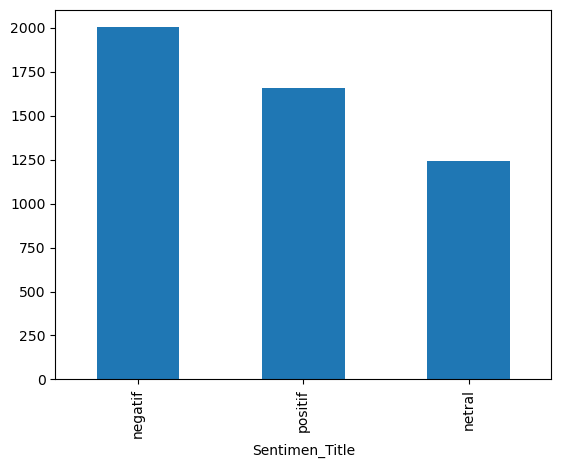

In [4]:
# Lihat distribusi sentimen
print(data["Sentimen_Title"].value_counts())
data["Sentimen_Title"].value_counts().plot(kind="bar")

In [5]:
import re

# Hapus URL
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', ' ', text) if isinstance(text, str) else text

# Hapus tag HTML
def remove_html(text):
    return re.sub(r'<.*?>', ' ', text) if isinstance(text, str) else text

# Hapus emoji
def remove_emoji(text):
    if not isinstance(text, str):
        return text
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F004-\U0001F0CF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(' ', text)

# Hapus mention @username
def remove_usernames(text):
    return re.sub(r'@\w+', ' ', text) if isinstance(text, str) else text

# Hapus angka
def remove_numbers(text):
    return re.sub(r'\d+', ' ', text) if isinstance(text, str) else text

# Hapus kalimat setelah tanda #
def remove_after_hashtag(text):
    if not isinstance(text, str):
        return text
    return text.split("#")[0]  # ambil hanya bagian sebelum #

# Hapus simbol dan tanda baca lalu rapikan spasi
def remove_symbols(text):
    if not isinstance(text, str):
        return text
    # Ganti semua simbol dengan spasi
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Rapikan spasi
    return re.sub(r'\s+', ' ', text).strip()

# Fungsi pembersihan lengkap
def clean_text(text):
    if not isinstance(text, str):
        return text

    text = remove_url(text)
    text = remove_usernames(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_after_hashtag(text)
    text = remove_numbers(text)      # angka dihapus
    text = remove_symbols(text)      # simbol dihapus + spasi rapi

    # Rapikan spasi akhir
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# --------------------------------------------
# TERAPKAN KE DATAFRAME
# --------------------------------------------
data['text'] = data['text'].apply(clean_text)


In [6]:
# CASE FOLDING (UBAH SEMUA KE HURUF KECIL)
data['text'] = data['text'].str.lower()
data

,Unnamed: 0.1,Sentimen_Title,text
0,0,netral,pemerintah meluncurkan program makan gratis ta...
1,1,negatif,harusnya lebih diawasi banyak sekolah belum dapat
2,2,negatif,maaf aku bacanya meeting mbg sedikit
3,3,netral,pemerintah meluncurkan program makan gratis ta...
4,4,negatif,masih banyak kekurangan terutama distribusinya
...,...,...,...
4894,4894,negatif,harusnya lebih diawasi banyak sekolah belum dapat
4895,4895,negatif,pelaksanaan mbg terkesan kurang terorganisir d...
4896,4896,positif,terima kasih atas program ini semoga terus ber...
4897,4897,negatif,masih banyak kekurangan terutama distribusinya


In [7]:
# GANTI KATA TIDAK BAKU DENGAN KATA BAKU

# Unduh kamus kata baku dari GitHub
url = "https://github.com/analysisdatasentiment/kamus_kata_baku/raw/main/kamuskatabaku.xlsx"
response = requests.get(url)
kamus_excel = BytesIO(response.content)

kamus_data = pd.read_excel(kamus_excel, engine="openpyxl")
kamus_tidak_baku_dict = dict(zip(kamus_data['tidak_baku'].str.lower(), kamus_data['kata_baku']))

# Tambahkan kamus manual (istilah khusus)
kamus_manual = {
    "mbg": "makan bergizi gratis",
    "sppg": "satuan pelayanan pemenuhan gizi",
    "bgn": "badan gizi nasional",
    "dpr": "dewan perwakilan rakyat",
    "dprd": "dewan perwakilan rakyat daerah",
    "slhs": "sertifikat laik higiene sanitasi",
    "kemenkes": "kementrian kesehatan",
    "menkes":"mentri kesehatan"
}

# Gabungkan kamus bawaan + manual
kamus_tidak_baku_dict.update(kamus_manual)

# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus):
    if isinstance(text, str):
        words = text.split()
        replaced = [kamus.get(word.lower(), word) for word in words]
        return ' '.join(replaced)
    return text

# Terapkan ke dataset
data['text'] = data['text'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku_dict))
data

,Unnamed: 0.1,Sentimen_Title,text
0,0,netral,pemerintah meluncurkan program makan gratis ta...
1,1,negatif,harusnya lebih diawasi banyak sekolah belum dapat
2,2,negatif,maaf aku bacanya meeting makan bergizi gratis ...
3,3,netral,pemerintah meluncurkan program makan gratis ta...
4,4,negatif,masih banyak kekurangan terutama distribusinya
...,...,...,...
4894,4894,negatif,harusnya lebih diawasi banyak sekolah belum dapat
4895,4895,negatif,pelaksanaan makan bergizi gratis terkesan kura...
4896,4896,positif,terima kasih atas program ini semoga terus ber...
4897,4897,negatif,masih banyak kekurangan terutama distribusinya


In [8]:
# TOKENIZING (PEMISAHAN KATA)

nltk.download('punkt')
data['text'] = data['text'].apply(word_tokenize)
data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0.1,Sentimen_Title,text
0,0,netral,"[pemerintah, meluncurkan, program, makan, grat..."
1,1,negatif,"[harusnya, lebih, diawasi, banyak, sekolah, be..."
2,2,negatif,"[maaf, aku, bacanya, meeting, makan, bergizi, ..."
3,3,netral,"[pemerintah, meluncurkan, program, makan, grat..."
4,4,negatif,"[masih, banyak, kekurangan, terutama, distribu..."
...,...,...,...
4894,4894,negatif,"[harusnya, lebih, diawasi, banyak, sekolah, be..."
4895,4895,negatif,"[pelaksanaan, makan, bergizi, gratis, terkesan..."
4896,4896,positif,"[terima, kasih, atas, program, ini, semoga, te..."
4897,4897,negatif,"[masih, banyak, kekurangan, terutama, distribu..."


In [9]:
# FILTERING (HAPUS STOPWORDS)
nltk.download('stopwords')

# Gunakan stopword Bahasa Indonesia dari NLTK
stop_words = set(stopwords.words('indonesian'))

# Tambahkan stopword tambahan (kata ga penting)
tambahan_stopwords = {'nih',}
stop_words.update(tambahan_stopwords)

def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

# Hapus stopword dan ubah kembali ke string
data['text'] = data['text'].apply(remove_stopwords).apply(lambda x: ' '.join(x))
data


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0.1,Sentimen_Title,text
0,0,netral,pemerintah meluncurkan program makan gratis
1,1,negatif,diawasi sekolah
2,2,negatif,maaf bacanya meeting makan bergizi gratis
3,3,netral,pemerintah meluncurkan program makan gratis
4,4,negatif,kekurangan distribusinya
...,...,...,...
4894,4894,negatif,diawasi sekolah
4895,4895,negatif,pelaksanaan makan bergizi gratis terkesan tero...
4896,4896,positif,terima kasih program semoga berlanjut
4897,4897,negatif,kekurangan distribusinya


In [10]:
# STEMMING (UBAH KE KATA DASAR)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

tqdm.pandas(desc="🔁 Stemming Progress")
data['text'] = data['text'].progress_apply(lambda x: stemmer.stem(x))
data

🔁 Stemming Progress: 100%|████████████████████████████████████████████████████████| 4899/4899 [08:41<00:00,  9.39it/s]


,Unnamed: 0.1,Sentimen_Title,text
0,0,netral,perintah luncur program makan gratis
1,1,negatif,awas sekolah
2,2,negatif,maaf baca meeting makan gizi gratis
3,3,netral,perintah luncur program makan gratis
4,4,negatif,kurang distribusi
...,...,...,...
4894,4894,negatif,awas sekolah
4895,4895,negatif,laksana makan gizi gratis kes organisir jadwal...
4896,4896,positif,terima kasih program moga lanjut
4897,4897,negatif,kurang distribusi


In [11]:
# SIMPAN HASIL AKHIR
data.to_csv('dc_tweets_mbg_fix2.csv', index=False)